请先填写姓名学号，同时修改文件名为学号，防止后面遗漏修改。

姓名：丁钊翰

学号：1700017720

# Task 1 图像分类

针对手写数字的识别任务，除了HOG特征，你能想到使用什么作为手写数字的特征描述符进行分类吗？比如说灰度值，灰度直方图，梯度值（sober算子计算），角点，SIFT...等，如果使用角点特征，sift特征这些局部特征，需要考虑如何将特征转化为每张图定长的向量（最少需要完成另外2种，完成更多种可自行添加cell）

## 1 读取图像数据

In [1]:
import cv2
import numpy as np


# 每个数字长宽均为20
SZ = 20
# 类别10
CLASS_N = 10

def split2d(img, cell_size, flatten=True):
    h, w = img.shape[:2]
    sx, sy = cell_size
    # 先按行切，后按列切
    cells = [np.hsplit(row, w//sx) for row in np.vsplit(img, h//sy)]
    cells = np.array(cells)
    if flatten:
        cells = cells.reshape(-1, sy, sx)
    return cells

def load_digits(fn):
    # 读取整图
    digits_img = cv2.imread(fn, 0)
    # 按照 20x20 切分数字图
    digits = split2d(digits_img, (SZ, SZ))
    # label为数字0到9
    labels = np.repeat(np.arange(CLASS_N), len(digits)/CLASS_N)
    return digits, labels

digits, labels = load_digits('images/digits.png')

print(digits.shape)
print(labels.shape)

(5000, 20, 20)
(5000,)


## 2 提取图像特征描述符

作为分类的向量，每个图像的向量维数应一致，如HOG向量根据参数设置，最后每张图的HOG向量均为144维

In [200]:
# HOG参数设置
winSize = (20,20)
blockSize = (8,8)
blockStride = (4,4)
cellSize = (8,8)
nbins = 9
derivAperture = 1
winSigma = -1.
histogramNormType = 0
L2HysThreshold = 0.2
gammaCorrection = 1
nlevels = 64
signedGradient = True
# HOG特征描述器
hog = cv2.HOGDescriptor(winSize,blockSize,blockStride,\
            cellSize,nbins,derivAperture,winSigma,\
            histogramNormType,L2HysThreshold,gammaCorrection,\
            nlevels, signedGradient)

# 对每张图都计算出144维hog向量
hog_descriptors = []
for img in digits:
    hog_descriptors.append(hog.compute(img))
    
hog_descriptors = np.squeeze(hog_descriptors)

print(hog_descriptors.shape)

(5000, 144)


In [202]:
features_descriptors = hog_descriptors
# 使用sklearn的train_test_split随机分训练集和测试集
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
        features_descriptors, labels, test_size=0.1, random_state=0)
from sklearn.svm import SVC
clf = SVC(gamma='auto')
# fit训练
clf.fit(X_train, y_train) 
# predict测试
y_pred = clf.predict(X_test)
# sklearn 用于分类的评价指标 -- 混淆矩阵，分类准确率
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

print(confusion_matrix(y_test, y_pred))
print('*' * 35)
print("Accuracy:   ", accuracy_score(y_test, y_pred))

[[56  1  0  0  0  0  0  0  0  0]
 [ 0 48  1  0  0  0  0  0  0  0]
 [ 0  0 49  0  1  0  0  0  0  0]
 [ 0  0  0 37  0  0  0  0  0  0]
 [ 0  0  1  0 40  0  1  0  0  0]
 [ 0  0  0  0  0 49  0  0  0  0]
 [ 0  0  0  0  0  0 46  0  0  0]
 [ 0  0  1  0  1  0  0 58  0  2]
 [ 0  0  0  2  0  1  1  0 52  1]
 [ 0  1  0  2  1  0  0  3  0 44]]
***********************************
Accuracy:    0.958


In [297]:
# 特征1  梯度
gradient_descriptor = []
for img in digits:
    x = cv2.Sobel(img,cv2.CV_16S,1,0)  
    y = cv2.Sobel(img,cv2.CV_16S,0,1)   
    dst = cv2.addWeighted(x,0.5,y,0.5,0)  
    dst = dst.reshape(1, 400)
    dst = dst/dst.max()
    gradient_descriptor.append(dst)
gradient_descriptor = np.squeeze(gradient_descriptor)
features_descriptors = gradient_descriptor
# 使用sklearn的train_test_split随机分训练集和测试集
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
        features_descriptors, labels, test_size=0.1, random_state=0)
from sklearn.svm import SVC
clf = SVC(gamma='auto')
# fit训练
clf.fit(X_train, y_train) 
# predict测试
y_pred = clf.predict(X_test)
# sklearn 用于分类的评价指标 -- 混淆矩阵，分类准确率
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

print(confusion_matrix(y_test, y_pred))
print('*' * 35)
print("Accuracy:   ", accuracy_score(y_test, y_pred))

[[54  0  0  1  0  1  0  0  1  0]
 [ 0 48  0  0  0  0  0  1  0  0]
 [ 0  0 45  2  0  0  1  0  2  0]
 [ 0  0  2 32  0  0  1  1  0  1]
 [ 0  0  1  0 36  3  1  0  1  0]
 [ 2  1  0  1  0 42  2  0  0  1]
 [ 1  0  0  0  0  2 43  0  0  0]
 [ 2  4  0  0  0  0  0 56  0  0]
 [ 0  0  0  2  0  4  0  1 49  1]
 [ 1  3  0  0  1  2  0  5  0 39]]
***********************************
Accuracy:    0.888


In [284]:
# 特征2 灰度值
gray_d = []
for img in digits:
    img = img.reshape(1, 400)
    img = img/img.max()
    gray_d.append(img)
gray_d = np.squeeze(gray_d)
features_descriptors = gray_d
# 使用sklearn的train_test_split随机分训练集和测试集
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
        features_descriptors, labels, test_size=0.1, random_state=0)
from sklearn.svm import SVC
clf = SVC(gamma='auto')
# fit训练
clf.fit(X_train, y_train) 
# predict测试
y_pred = clf.predict(X_test)
# sklearn 用于分类的评价指标 -- 混淆矩阵，分类准确率
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

print(confusion_matrix(y_test, y_pred))
print('*' * 35)
print("Accuracy:   ", accuracy_score(y_test, y_pred))

[[56  0  0  0  0  0  0  0  1  0]
 [ 0 48  0  0  0  0  0  1  0  0]
 [ 0  0 47  0  0  0  0  1  2  0]
 [ 0  0  2 33  0  0  0  1  0  1]
 [ 0  1  1  0 36  0  1  0  1  2]
 [ 1  1  0  0  1 44  1  0  1  0]
 [ 0  0  0  0  1  2 43  0  0  0]
 [ 1  4  0  0  1  0  0 56  0  0]
 [ 0  0  1  2  0  4  0  0 49  1]
 [ 1  2  1  0  0  1  0  5  0 41]]
***********************************
Accuracy:    0.906


In [299]:
# 特征3角点
cornerHarris_descriptors = []
for img in digits:
    dst = cv2.cornerHarris(img, 2, 3, 0.04)
    dst = dst.reshape(1, 400)
    dst = dst/dst.max()
    cornerHarris_descriptors.append(dst)
cornerHarris_descriptors = np.squeeze(cornerHarris_descriptors)
features_descriptors = cornerHarris_descriptors
# 使用sklearn的train_test_split随机分训练集和测试集
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
        features_descriptors, labels, test_size=0.1, random_state=0)
from sklearn.svm import SVC
clf = SVC(gamma='auto')
# fit训练
clf.fit(X_train, y_train) 
# predict测试
y_pred = clf.predict(X_test)
# sklearn 用于分类的评价指标 -- 混淆矩阵，分类准确率
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

print(confusion_matrix(y_test, y_pred))
print('*' * 35)
print("Accuracy:   ", accuracy_score(y_test, y_pred))


[[49  1  1  1  1  2  1  1  0  0]
 [ 0 48  1  0  0  0  0  0  0  0]
 [ 0  0 45  2  0  0  0  0  3  0]
 [ 0  0  2 29  0  0  0  3  3  0]
 [ 0  0  2  2 35  1  1  0  1  0]
 [ 0  0  3  6  7 30  0  0  1  2]
 [ 0  0  0  0  0  0 45  0  1  0]
 [ 1  0  3  1  1  0  0 54  2  0]
 [ 1  0  3  6  0  0  0  0 47  0]
 [ 0  0  3  0  3  1  1  5  1 37]]
***********************************
Accuracy:    0.838


In [298]:
# 特征4 sift特征
sift_descriptros = []
for img in digits:
    sift = cv2.xfeatures2d.SIFT_create()
    kps, des = sift.detectAndCompute(img, None)
    if des is None:
        sift_descriptros.append([[0]*128])
        continue
    tmp = des.sum(axis=0)
    tmp = tmp.reshape(1,128)
    tmp = tmp/tmp.max()
    sift_descriptros.append(tmp)
sift_descriptros = np.squeeze(sift_descriptros)
features_descriptors = sift_descriptros
# 使用sklearn的train_test_split随机分训练集和测试集
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
        features_descriptors, labels, test_size=0.1, random_state=0)
from sklearn.svm import SVC
clf = SVC(gamma='auto')
# fit训练
clf.fit(X_train, y_train) 
# predict测试
y_pred = clf.predict(X_test)
# sklearn 用于分类的评价指标 -- 混淆矩阵，分类准确率
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

print(confusion_matrix(y_test, y_pred))
print('*' * 35)
print("Accuracy:   ", accuracy_score(y_test, y_pred))

[[43  3  3  2  1  0  3  0  1  1]
 [ 0 48  0  0  1  0  0  0  0  0]
 [ 5  3 28  2  2  0  5  2  3  0]
 [ 0  2  3 25  1  0  1  0  3  2]
 [ 1  0  7  1 25  0  0  2  2  4]
 [ 3 10  5  6  0 21  1  2  0  1]
 [ 3  4  0  0  0  2 27  2  1  7]
 [ 3 19  5  1  2  0  2 27  0  3]
 [ 7  2  4  5  0  0  5  0 32  2]
 [12  6  5  1  1  1  4  1  2 18]]
***********************************
Accuracy:    0.588


# Task 2 图像拼接
你是否好奇全景图是如何实现的？Task2 将带你从图像拼接的方法实现全景图功能。   
OpenCV虽然有包装好的拼接功能，但是作业这里希望同学们通过ORB特征匹配实现（SIFT已给出）。

主要可分为以下四步
- 从输入的两张图片里检测关键点、提取局部不变特征
- 匹配的两幅图像之间的特征
- 使用RANSAC算法估计单应矩阵（homography matrix）
- 合成全景图

参考资料：   
[图像拼接基本步骤](https://blog.csdn.net/datase/article/details/72327400)   
[OpenCV探索之路（二十四）图像拼接和图像融合技术](https://www.cnblogs.com/skyfsm/p/7411961.html)

In [182]:
from matplotlib import pyplot as plt
import numpy as np
import cv2
%matplotlib inline

## 1 读取图片

In [183]:
# 读取BGR图片
# 'images/left.png' & 'images/right.png'
limg = cv2.imread('images/left.png')
rimg = cv2.imread('images/right.png')

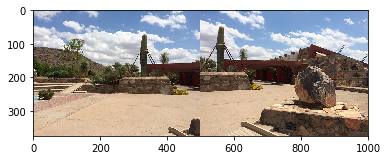

In [186]:
plt.imshow(cv2.cvtColor(np.concatenate([limg, rimg], axis=1), cv2.COLOR_BGR2RGB))

## 2 检测特征点，提取特征描述符
可以使用 SIFT特征 或者 ORB特征（但是要注意，如果使用ORB特征，下一步的Matcher的参数需要设置为cv2.NORM_HAMMING）

In [192]:
# SIFT特征
sift = cv2.xfeatures2d.SIFT_create()
lkps, ldes = sift.detectAndCompute(limg, None)
rkps, rdes = sift.detectAndCompute(rimg, None)

In [295]:
# 定义ORB特征检测器，检测关键点和描述符
ORB = cv2.ORB_create()
lkps, ldes = ORB.detectAndCompute(limg, None)
rkps, rdes = ORB.detectAndCompute(rimg, None)

## 3 特征点匹配
注意SIFT特征和ORB特征的区别

In [193]:
# SIFT特征
bf_matcher = cv2.BFMatcher(cv2.NORM_L2)
matches = bf_matcher.knnMatch(ldes, rdes, k=2)
# 对特征点进行一定的过滤
good_matches = []
for m, n in matches:
    if m.distance < 0.75 * n.distance:
        good_matches.append(m)

In [188]:
#　定义匹配器，进行特征匹配
bf_matcher = cv2.BFMatcher(cv2.NORM_HAMMING)
matches = bf_matcher.knnMatch(ldes, rdes, k=2)
# 对特征点进行一定的过滤
good_matches = []
for m, n in matches:
    if m.distance < 0.75 * n.distance:
        good_matches.append(m)


## 4 通过匹配点估算单应性矩阵

In [194]:
# 估算单应性矩阵（以左图为基准，计算右图到左图的变换）
assert len(good_matches) >= 4, "匹配点数小于4，无法估算单应性矩阵H"
# 左图的点
lpts = np.float32([lkps[m.queryIdx].pt for m in good_matches])  
# 右图的点
rpts = np.float32([rkps[m.trainIdx].pt for m in good_matches])  
# 估算单应性矩阵（注：以左图为基准，计算右图到左图的变换）
H, mask = cv2.findHomography(rpts, lpts, cv2.RANSAC, 5)

## 5 合成全景图
示例仅有两张图，如果是多张图的话，可以以中间的图像为基准，左右的图像都映射到和中间图像同一个平面上

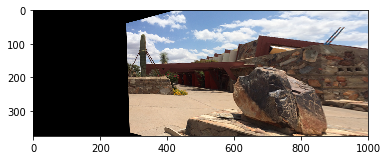

In [195]:
# 通过H，将右图投影到和左图相同的平面
result = cv2.warpPerspective(rimg, H, (limg.shape[1] + rimg.shape[1], rimg.shape[0]))
plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))

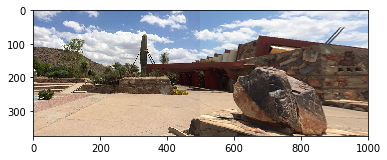

In [196]:
# 左图不变换，加上左图，得到全景图
result[0:limg.shape[0], 0:limg.shape[1]] = limg
plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))